## Проект: Анализ результатов АБ тестирования новой механики оплаты (Вариант 2)

#### 1. Общие положения
Цель данного проекта — определить, стоит ли внедрять новую механику оплаты для всех пользователей на основе результатов A/B-тестирования.

#### 2. Входные данные

- **groups.csv**: Содержит информацию о принадлежности пользователя к контрольной (А) или экспериментальной (B) группе.
  
- **groups_add.csv**: Дополнительные данные о принадлежности пользователей к группам, полученные через 2 дня после начальной передачи данных.

- **active_studs.csv**: Данные о пользователях, которые посещали платформу во время проведения эксперимента.

- **checks.csv**: Данные об оплате услуг пользователями во время проведения эксперимента.

#### 3. Задачи анализа

1. **Метрики анализа**: Определить ключевые метрики, на которые следует обратить внимание при анализе результатов эксперимента.

2. **Анализ различий**: Установить, существуют ли статистически значимые различия между контрольной и экспериментальной группами.

3. **Выводы**: На основе проведенного анализа решить, стоит ли внедрять новую механику оплаты для всех пользователей.


# Начало анализа

Импортирую нужные библиотеки

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from scipy.stats import kurtosis
from scipy.stats import levene
from scipy.stats import ttest_ind
import numpy as np
import warnings


plt.style.use('ggplot')
warnings.filterwarnings("ignore")

Проведу предварительный анализ таблиц необходимых для выполнения первого задания об оценке результатов эксперемента

Загружу информацию о распределении пользователей между контрольной(А) и эксперементальной(В) группой

In [143]:
groups = pd.read_csv('/Users/filippnevedrov/KARPOV.ANALITICS/Final_Project/groups.csv', sep = ';')

In [144]:
groups.shape

(74484, 2)

In [145]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [146]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [147]:
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

Эксперементальная группа в 4 раза больше по объему чем контрольная.

Загружу данные о студентах, активных во время проведения эксперемента

In [148]:
active_students = pd.read_csv('/Users/filippnevedrov/KARPOV.ANALITICS/Final_Project/active_studs.csv')

In [149]:
active_students.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [150]:
active_students.isna().sum()

student_id    0
dtype: int64

In [151]:
active_students.shape

(8341, 1)

Загружу информацию об оплатах во время проведения эксперемента

In [152]:
checks = pd.read_csv('/Users/filippnevedrov/KARPOV.ANALITICS/Final_Project/checks.csv', sep = ';')

In [153]:
checks.shape

(541, 2)

In [154]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [155]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

Ни в каких таблицах нет пропусков, что хорошо. 

**Для оценки результатов эксперемента считаю нужным сравнить следующие метрики -**
- Конверсия в оплату: Сравнитьпроцент пользователей, совершивших оплату, в контрольной и экспериментальной группах. (CR в покупку)
- Средний чек среди платящих клиентов (ARPPU)
- Средний чек оплаты между двумя группами. (ARPU)


Для подсчета конверсии в покупку необходимо сравнивать количество оплативших пользователей с общим количеством пользователей активных во время эксперимента (по каждой группе), учитывать пользователей не заходивших на плтаформу в данный период нецелесообразно, поэтому отберу только нужных нам пользователей

Посмотрю были ли пользователи совершившие оплату в момент эксперимента, но каким то образом не заходившие в этот момент на платформу:


In [156]:
not_active_payed = checks[~checks['student_id'].isin(active_students['student_id'])]

In [157]:
not_active_payed.head()

,student_id,rev
1,3185,690.0
2,25973,690.0
3,26280,690.0
5,100645,630.0
6,102534,580.0


In [158]:
not_active_payed.shape

(149, 2)

Число клентов оплативших, но не пользовавшихся платформой в момет эксперемента соствляет значительную часть от всех оплативших клиентов, возможно они могли узнать о новой механнике и воспользоавться ей не заходя на плтаформу. Посмотрим к какой группе относяться эти клиенты  

In [159]:
not_active_payed = not_active_payed.merge(groups, left_on = 'student_id', right_on = 'id')

not_active_payed.grp.value_counts()

B    120
A     29
Name: grp, dtype: int64

Значительное число клиентов из эксперементальной группы произвело оплату не пользуюясь при этом платформой, предполагаю что они могли узнать о новой механнике совершения оплаты с помощью рассылки или каким то другим способом (возможно пользователи могут заходить на сайт,не пользуясь при этом самой платформой) и воспользовались эй, так же возможно это ошибка сбора данных. Считаю неверным учитывать их на равне с активными участниками, группу неактивных пользователей так же можно проанализировать отдельно, но желательно сначала получить дополнительную информацию.

Посмотрим так же на отношение активных студентов из контрольной и эксперементальной групп. 

In [160]:
active_students = active_students.merge(groups, left_on = 'student_id', right_on = 'id', how = 'left')

active_students.isna().sum()

student_id     0
id            13
grp           13
dtype: int64

Нашли 3 студентов без указания группы, их не так много, поэтому дропнем

In [161]:
active_students.dropna(inplace = True)

active_students.isna().sum()

student_id    0
id            0
grp           0
dtype: int64

In [162]:
active_students.grp.value_counts()

B    6793
A    1535
Name: grp, dtype: int64

Нужно решить что делать с неактивными, но оплатившими студентами. Если новая механника оплаты подразумевает что пользователи были оповещены о ее подключении каким то образом, считаю некоррктым добавлять этих студентов и сравнивать на равне с активными. Рассылку могли получить все студенты эксперементальной группы, которых в 4 раза больше чем студентов контрольной группы. А отреагировать на нее только заинтересованные в нашем продукте пользователи. В тоже время пользователи контрольной группы не получали никакого напоминания о продукте. Самым логичным решением для анализа этой группы без учета дополнительной информации вижу сравнивать отдельно активных пользователей (пользователей априори интересующихся нашим продуктом) и неактивных пользователей, для этого взять равные рандомные выборки из неактивных польователей и посмотреть на интересующие нас метрики, так же нужно удостовериться что пользователи в выборке приблизительно похожи по дате регистрации(предположу что id релевантно дате регистрации)

## Структурирую действия для корректного анализа результатов эксперимента:

**Сегментая пользователей:**

Активные пользователи: те, кто заходил на платформу во время эксперимента.

Неактивные пользователи: те, кто не заходил на платформу во время эксперимента, но совершил оплату.

**Анализ активных пользователей:**
Сравню ключевые метрики между контрольной и экспериментальной группами среди активных пользователей.
Примению статистические методы для определения значимости различий.

**Анализ неактивных пользователей (опционально) :**
Для сравнения контрольной и экспериментальной групп среди неактивных пользователей создам равные рандомные выборки.
Проверю дополнительные условия, например, равенство распределения ID пользователей.
Аналогично активным, сравню ключевые метрики и определю статистическую значимость различий.

# Анализ активных пользователей

### Оценка CR в покупку：

Добравлю информацию об оплатах для активных пользователей

In [163]:
active_students_checks = active_students.merge(checks, on = 'student_id', how = 'left')

#create a column indecated if the student paid or nor 
active_students_checks['paid'] = ~active_students_checks['rev'].isna() 

#fill 0 pays with 0
active_students_checks = active_students_checks.fillna(0)

active_students_checks['paid'] = active_students_checks['paid'].astype(int)

active_students_checks = active_students_checks.drop('id', axis = 1)

active_students_checks.head()

,student_id,grp,rev,paid
0,581585,A,0.0,0
1,3276743,B,0.0,0
2,4238589,A,0.0,0
3,4475369,B,0.0,0
4,5481015,B,0.0,0


In [164]:
pd.crosstab(active_students_checks.paid,active_students_checks.grp)

grp,A,B
paid,,
0,1457,6480
1,78,313


<Axes: xlabel='grp', ylabel='count'>

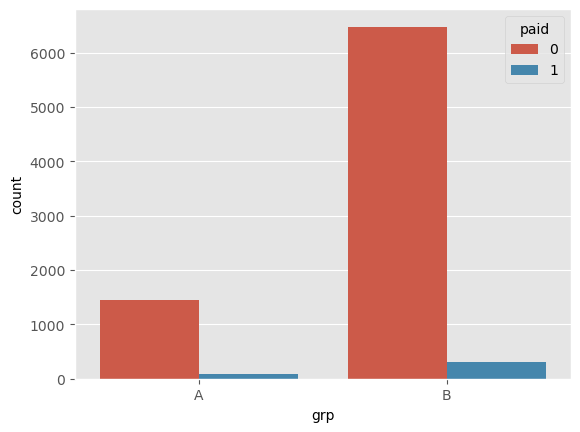

In [165]:
sns.countplot(x = 'grp', data = active_students_checks, hue = 'paid')

Разделю датасэт на группы для удобства работы

In [166]:
#split groups

group_A = active_students_checks[active_students_checks['grp'] == 'A']

group_B = active_students_checks[active_students_checks['grp'] == 'B']


Посмотрю на CR в оплату


In [167]:
round(group_A.paid.value_counts(normalize = True)*100,2)

0    94.92
1     5.08
Name: paid, dtype: float64

In [168]:
round(group_B.paid.value_counts(normalize = True)*100, 2)

0    95.39
1     4.61
Name: paid, dtype: float64

### Kонверсия в оплату (CR):
Группа A: примерно 5.08%     
Группа B: примерно 4.61%

In [169]:
df_crosstab = pd.crosstab(active_students_checks.paid,active_students_checks.grp)

df_crosstab

grp,A,B
paid,,
0,1457,6480
1,78,313


<Axes: xlabel='grp', ylabel='count'>

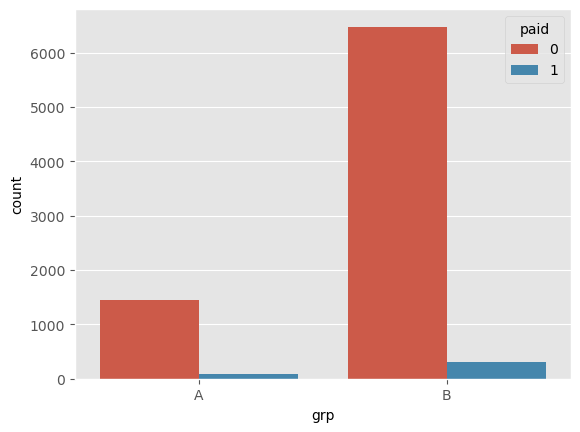

In [170]:
sns.countplot(x = 'grp', data = active_students_checks, hue = 'paid')

Так как мы работаем с категориальными данными, и нам необходимо сравнить пропорции(конверсия в покупку), буду использовать критерий чи-квадрат. 

 - **0-я гипотеза** -  различия в конверсиях случайны
 - **Альтернативная гипотеза** - различия в конверсиях стат значимы 

In [171]:
res = chi2_contingency(df_crosstab)

res.statistic

0.526607176998989

In [172]:
res.pvalue

0.46803677583199144

## Для сравниния конверсии в оплату был применет статистический критерий чи-квадрат


- 0-я гипотеза - разница между показателями случайна и не зависит от группы
- Альтернативная гипотеза - разница между показателями зависит от группы

**п-значение ~ 0.47, что значительно выше уровня значимости -  это не дает нам оснований отклонить нулевую гипотезу, между группами нет стат. значимой разниы в конверсию в покупку**


## Сравнение ARPPU 

In [173]:
active_students_checks.head()

,student_id,grp,rev,paid
0,581585,A,0.0,0
1,3276743,B,0.0,0
2,4238589,A,0.0,0
3,4475369,B,0.0,0
4,5481015,B,0.0,0


Посмотрим на распределение оплат каждого пользователя

<Axes: xlabel='rev', ylabel='Count'>

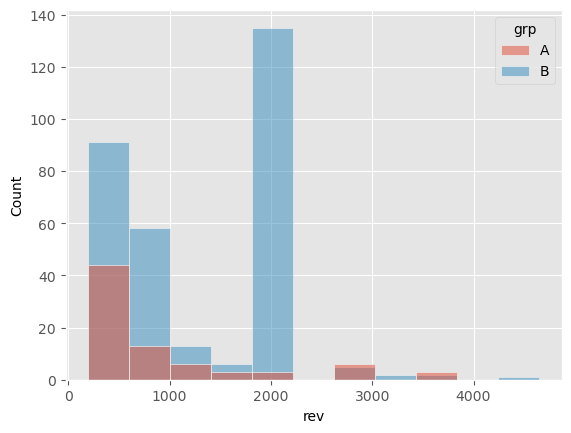

In [174]:
sns.histplot(data=active_students_checks[active_students_checks['paid'] == 1], x='rev', hue='grp')

<Axes: xlabel='grp', ylabel='rev'>

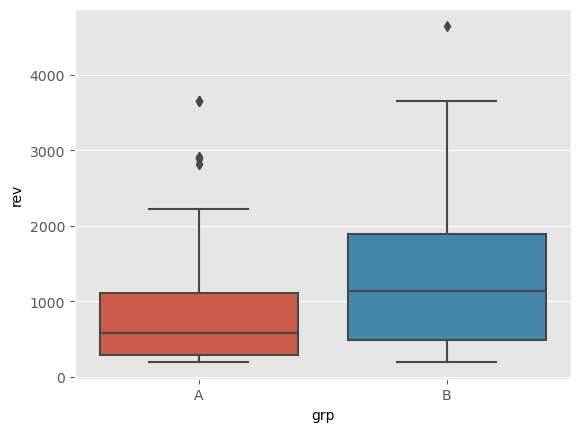

In [175]:
sns.boxplot(data=active_students_checks[active_students_checks['paid'] == 1], x='grp', y='rev')

По графикам видем что распределения не являются нормальными, в группе А большинство платежей сосредоточено в районе до 1000 рублей, в группе В в районе 2000, так же из боксплтов видим что в группе А и В присутствуют выбросы

Посмотрим на средний чек не делая ничего с выбросами

In [176]:
round(active_students_checks[active_students_checks['paid'] == 1].groupby('grp')['rev'].mean(),2)

grp
A     933.59
B    1255.83
Name: rev, dtype: float64

## ARPPU в группах:

    - A - 933.59 р
    
    - B - 1255.83 р

Отберем и посмотрим аномальные значения:

In [177]:
# Calculate Q1, Q3, and IQR
Q1 = group_A[group_A['paid'] ==1 ]['rev'].quantile(0.25)
Q3 = group_A[group_A['paid'] ==1 ]['rev'].quantile(0.75)
IQR = Q3 - Q1

# Calculate bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify potential outliers
anomalies_A = group_A[(group_A['rev'] < lower_bound) | (group_A['rev'] > upper_bound)]

print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")
print("Anomalies:")
print(anomalies_A)

Lower bound: -947.125
Upper bound: 2351.875
Anomalies:
      student_id grp     rev  paid
390       332387   A  2910.0     1
589      1624158   A  3660.0     1
1603     2150601   A  3660.0     1
1670     4002619   A  2890.0     1
2090      347455   A  2820.0     1
2203      594228   A  2900.0     1
3477     2455897   A  2820.0     1
7937      445767   A  3660.0     1
8012     1202202   A  2910.0     1


In [178]:
# Calculate Q1, Q3, and IQR
Q1 = group_B[group_B['paid'] ==1 ]['rev'].quantile(0.25)
Q3 = group_B[group_B['paid'] ==1 ]['rev'].quantile(0.75)
IQR = Q3 - Q1

# Calculate bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify potential outliers
anomalies_B = group_B[(group_B['rev'] < lower_bound) | (group_B['rev'] > upper_bound)]

print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")
print("Anomalies:")
print(anomalies_B)

Lower bound: -1627.5
Upper bound: 4016.5
Anomalies:
      student_id grp     rev  paid
3983     1711305   B  4650.0     1


## Количество аномальных значений:
    - Группа А - 9
    - Группа В - 1
Предполагаю что в обе группы попались супер-вип клиенты, но их количество в каждой группе распределено не равномерно. Возможно тестируемая механника положительно повлияла бы на вип-клиентов, если бы они были распределены в группу В. Поэтому считаю корректным не использовать данные student_ID для сравнения результатов.

Избавимся от аномальных значений:

In [179]:
anomalies = pd.concat([anomalies_A, anomalies_B], ignore_index=True)

active_students_checks = active_students_checks[~active_students_checks['student_id'].isin(anomalies['student_id'])]

Взглянем снова на показатели ARPPU

In [180]:
round(active_students_checks[active_students_checks['paid'] == 1].groupby('grp')['rev'].mean(),2)

grp
A     646.23
B    1244.95
Name: rev, dtype: float64

## ARPPU в группах без аномальных значений:

    - A - 646.23 р
    
    - B - 1244.95 р

Теперь применим статистический критерий что бы удостовериться в том, что разница является статистически значимой.

Распределения явно отличаются от нормальных, но это не говорит о том что мы не можем использовать Т-Критерий для определения стат. значимой разницы.
Т-критерий по прежнему можно использовать если выборочные средние образует нормальное распределение. Так как объем наблюдений достаточно большой и данные не имеют большого количеста аномальных значений выберу один из вариантов Т-критерия

**Т-критерий Стьюдента** - если данные Гомоскедастичны (дисперсии распрделений одинаковы)
**Т-критерий Уэлча** - если данные Гетерокседастичны (диспресии распределений неодинаковы)

Для ороеделения Гомоскедастичности проведем тест **Левена**:

- **0-я гипотеза** - дисперсии распрделений одинаковы
- **Альтернативная гипотеза** - диспресии распределений неодинаковы

In [181]:
active_students_checks[active_students_checks['paid'] == 1].grp.value_counts()

B    312
A     69
Name: grp, dtype: int64

In [182]:
group_A = active_students_checks[(active_students_checks['paid'] == 1) & (active_students_checks['grp'] == 'A')]

group_B = active_students_checks[(active_students_checks['paid'] == 1) & (active_students_checks['grp'] == 'B')]

In [183]:
levene_test = levene(group_A.rev, group_B.rev)

levene_test

LeveneResult(statistic=62.19504994374272, pvalue=3.35511601487199e-14)

**p-значение** гораздо ниже стандартного порога 0.05, что указывает на значимое различие в дисперсиях между двумя группами (гетероскедастичность), поэтому буду использовать Т-Критерий Уэлча

- 0я гипотеза - разница между ARPPU не стат. значима
- Альтернативная гипотеза - разница между ARPPU стат. значима

In [184]:
# Т-критерий Уэлча для определения статистической значимости разницы в средних чеках

t_statistic, p_value = ttest_ind(group_A.rev, group_B.rev, equal_var=False)

t_statistic, p_value

(-8.472630916952053, 1.3419957176838584e-14)

## Оценка результата: 
Очень низкое p-значение говорит о том, что различия в средних чеках между группами A и B статистически значимы. Следовательно, мы можем отвергнуть нулевую гипотезу о том, что различий между средними чеками (среди платящих клиенов)нет.

## Теперь оценим средний чек (ARPU), для групп и проверим стат значимость различий с помощью метода bootstrap

Для начала посчитаем средний чек 

In [185]:
#split groups

group_A = active_students_checks[active_students_checks['grp'] == 'A']

group_B = active_students_checks[active_students_checks['grp'] == 'B']

arpu_A = group_A.rev.sum()/len(group_A)

arpu_B = group_B.rev.sum()/len(group_B)

print(f'ARPU в контрольной группе - {arpu_A}')
print(f'ARPU в эксперементальной группе - {arpu_B}')

ARPU в контрольной группе - 29.220183486238533
ARPU в эксперементальной группе - 57.188457523557126


Теперь используем метод бутстрэп для того что бы удостовериться что разница величине среднего чека является статистически значимой

In [186]:
# Количество бутстрап-повторений
n_iterations = 10000

# Создание пустых списков для хранения результатов бутстрапа для каждой группы
bootstrap_A = []
bootstrap_B = []

# Генерация бутстрап-выборок и расчет среднего чека для каждой выборки
np.random.seed(0)  # для воспроизводимости результатов
for _ in range(n_iterations):
    sample_A = group_A.sample(frac = 1, replace=True)
    sample_B = group_B.sample(frac = 1, replace=True)
    
    total_sample_A = np.mean(sample_A['rev'])
    total_sample_B = np.mean(sample_B['rev'])
    
    bootstrap_A.append(total_sample_A)
    bootstrap_B.append(total_sample_B)

# Расчет 95% доверительного интервала для разности суммы выручки
alpha = 0.95
lower = ((1.0-alpha)/2.0) * 100
upper = (alpha+((1.0-alpha)/2.0)) * 100

# Получение границ доверительного интервала
bootstrap_diff = np.subtract(bootstrap_B, bootstrap_A)
lower_bound = np.percentile(bootstrap_diff, lower)
upper_bound = np.percentile(bootstrap_diff, upper)

# Результаты: границы доверительного интервала для разности выручек
lower_bound, upper_bound

(17.019323104799025, 38.971509351095534)

## Результаты Bootstrap
Результаты исследования показывают 95%-ный доверительный интервал для разницы в среднем чеке между группами A и B. 
Это означает, что с 95%-ной вероятностью истинное значение разницы в среднем чеке лежит в пределах этого интервала.
Нижняя граница интервала больше нуля, это указывает на статистически значимое увеличение среднего чека в группе B по сравнению с группой A. 

### Таблица с результирующими метриками **(с подчиещенными данными для коректного сравнения результатов АБ теста)** 

In [187]:
arppu = active_students_checks[active_students_checks['paid'] == 1].groupby('grp', as_index = False).agg({'rev':'mean'})

key_metrics = active_students_checks.groupby('grp', as_index = False).agg({
    'student_id':'nunique',
    'rev': ['sum', 'mean'],
    'paid': [lambda x: x.sum() / x.count()]
}).merge(arppu, on = 'grp').drop('grp', axis = 1)


key_metrics.columns = ['group','student_count','total_rev', 'arpu', 'cr', 'arppu']

key_metrics

,group,student_count,total_rev,arpu,cr,arppu
0,A,1526,44590.0000,29.220183,0.045216,646.231884
1,B,6792,388424.0035,57.188458,0.045936,1244.948729


## **Финальные результаты:**
- Для оценки результатов внедрения новой механники оплаты был проведен  анализ результатов АБ теста.
    
### **Выявленные аномалии в момент проведения анализа （требуют уточнения）:** 

**- 13 студентов без распределения по группам** невозможно учитывать при анализе.
   
**- Плятящие, но не активные пользователи:** принято решение работать с активными пользователями
            
**- Аномально высокие значения оплаты** - В числе активных пользователей было найдено 10 пользователей с экстремально высокими оплатами, в 5-6 раз выше среднего в группе: принято решение рассматривать этих пользователей как вип клиентов, но из за неравномерного их распределения по группам принятно решение не использовать их для оценки результатов.


### Выбранные метрики:
 - CR в покупку
 - ARPU
 - ARPPU
### Результаты
 - CR не претерпел статистически значимых различий, это говорит о том что новая механника оплаты не отпугнула потенциальных покупателей
 - APRU изменился с 29 до 57 рублей, что является статистически значимым различием, и говорит что новая механника положительно повлияла на увеличение среднего чека
 - ARPPU так же изменился с 646 до 1288 рублей, разница в 2 раза так же является статистически значимой. 
    
### Выводы 
Так как новая механника не оказала значительных изменений на конверсию в покупателя, увеличение ARPPU и APRU положительно, но важно убедиться, что увеличение доходов также перевешивает любые дополнительные затраты, связанные с внедрением новой механики. Если потенциальная прибыль превышает затраты， и мои предположения по поводу аномалий верны - рекомендую новую систему к запуску в продакшн
    

Теперь напишем функцию для автоматического добавления изначально не распределенных студентов по группам А и Б

In [188]:
add = pd.read_csv('group_add.csv')

add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [189]:
add.shape

(92, 2)

In [190]:
groups = pd.read_csv('groups.csv', sep = ';')

groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [191]:
groups.shape

(74484, 2)

In [192]:
active = pd.read_csv('active_studs.csv', sep = ';')

active.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [193]:
checks = pd.read_csv('checks.csv', sep = ';')

checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


Теперь посмотрим на метрики **без подготовки данных для сравнения результатов АБ теста**

In [194]:
# active merge groups(inner) merge checks (left)

act_sts_checks = active.merge(groups, left_on = 'student_id', right_on = 'id').merge(checks, on = 'student_id', how = 'left').fillna(0)

act_sts_checks['paid'] = act_sts_checks['rev'] != 0

arppu = act_sts_checks[act_sts_checks['paid'] == 1].groupby('grp', as_index = False).agg({'rev':'mean'})

key_metrics = act_sts_checks.groupby('grp', as_index = False).agg({
    'student_id':'nunique',
    'rev': ['sum', 'mean'],
    'paid': [lambda x: x.sum() / x.count()]
}).merge(arppu, on = 'grp').drop('grp', axis = 1)


key_metrics.columns = ['group','student_count','total_rev', 'arpu', 'cr', 'arppu']

key_metrics

,group,student_count,total_rev,arpu,cr,arppu
0,A,1535,72820.0000,47.439739,0.050814,933.589744
1,B,6793,393074.0035,57.864567,0.046077,1255.827487


Теперь посчитаем метрики с учетом дополнительных данных о распределении учеников по группам и обернем это в функуию которая принимает 4 файла и выдает таблицу с результами. 

Так как функция в любом случае будет обрабатывать все изначальные таблицы, а не видоизменять финальную таблицу с метриками, считаю логичным что бы для удобстава она принимала все возможные данные + файл с доболнительной информацией **(опционально)**

Таким образом мы сможем  не просто бобавлять информацию к файлу groups но и быстро посчитать метрики если какой то из файлов просто притерпел изменения 

In [195]:
def key_metrics(path_to_groups, path_to_active_studs, path_to_checks, path_to_group_add = None):

    groups = pd.read_csv(path_to_groups, sep=';')
    checks = pd.read_csv(path_to_checks, sep=';')
    active = pd.read_csv(path_to_active_studs, sep=';')
    
    # Проверяем есть ли у нас файл с дополнениями
    if path_to_group_add is not None:
        add = pd.read_csv(path_to_group_add)
        # Если есть - приелеиваем его к groups
        groups = pd.concat([groups, add], ignore_index=True)
    
    act_sts_checks = active.merge(groups, left_on='student_id', right_on='id')\
                           .merge(checks, on='student_id', how='left')\
                           .fillna(0)

    act_sts_checks['paid'] = act_sts_checks['rev'] != 0

    arppu = act_sts_checks[act_sts_checks['paid'] == 1].groupby('grp', as_index=False).agg({'rev':'mean'})

    key_metrics = act_sts_checks.groupby('grp', as_index=False).agg({
        'student_id':'nunique',
        'rev': ['sum', 'mean'],
        'paid': [lambda x: x.sum() / x.count()]
    }).merge(arppu, on='grp').drop('grp', axis=1)

    key_metrics.columns = ['group', 'student_count', 'total_rev', 'arpu', 'cr', 'arppu']

    return key_metrics

In [196]:
key_metrics('groups.csv','active_studs.csv','checks.csv', 'group_add.csv')

,group,student_count,total_rev,arpu,cr,arppu
0,A,1538,72820.0000,47.347204,0.050715,933.589744
1,B,6803,394974.0035,58.058798,0.046156,1257.878992


In [197]:
metrics = key_metrics('groups.csv','active_studs.csv','checks.csv', 'group_add.csv')

In [198]:
def plot_metrics(metrics):
    fig, (ax1, ax2, ax3)  = plt.subplots(1, 3, figsize=(20, 7))
    
    sns.barplot(data=metrics, y='group', x='cr', ax=ax1)
    sns.despine()
    ax1.set_title('CR в покупку', fontsize=15)
    
    sns.barplot(data=metrics, y='group', x='arpu', ax=ax2)
    sns.despine()
    ax2.set_title('ARPU', fontsize=17)
    
    sns.boxplot(data=act_sts_checks[act_sts_checks['paid'] == 1], x='rev', y='grp',  ax=ax3)
    sns.despine()
    ax3.set_title('REV cреди оплативших клиентов', fontsize=17)
    
    plt.show()

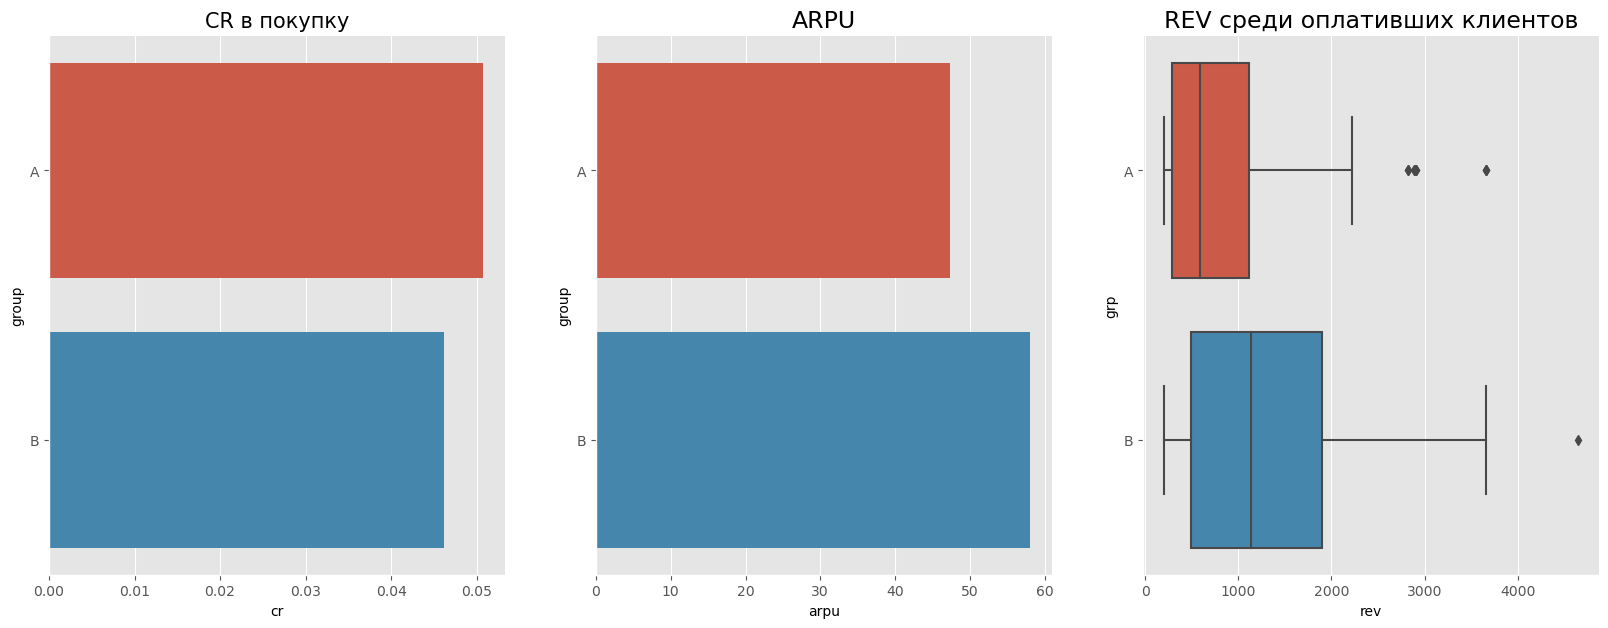

In [199]:
plot_metrics(metrics)

#### Было реализовано 2 функции 

- **key_metrics** - подсчет ключевых метрик
- **plot_metrics** - визуализация CR и APRU отображены в виде барплотов, 3ий график - боксплот для более наглядного представляения распределения выручки среди оплативших клиентов так же из этого графика можно увидеть среднее значение выручки